# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from joblib import load

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Constantes e funções auxiliares

In [3]:
FILE_MARKETPLACES = '../datasets/label_issues/20240423/results/marketplaces.parquet'
FILE_SUPERVISAO_MERCADO = '../datasets/supervisao_mercado/supervisao_mercado.xlsx'
FILE_MODEL_CLF3 = '../experimentos/assets/exp_clf3_model.joblib'
FILE_HYPER_PARAMETERS = '../datasets/gs_hyper_paramenters_classifiers.json'

In [4]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [5]:
# def tokenizer(doc):
#     doc = doc.lower()
#     doc = unidecode.unidecode(doc)
    
#     # uniformizar termos
#     patterns = [('wi\s?.?fi', 'wifi'), 
#                 ('2,4', '2.4'), 
#                 ('5,8', '5.8')]
#     for pattern, repl in patterns:
#         doc = re.sub(pattern, repl, doc)
    
#     stop_words = stopwords.words('portuguese')
#     stop_words.extend(stopwords.words('english'))
#     stop_words.extend(list(punctuation))
#     # stopwords específicas do domínio
#     stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
#     # cores mais comumns
#     stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
#     # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
#     # stop_words.remove('sem') 
    
#     tokens = [token for token in word_tokenize(doc) if token not in stop_words]

#     # tokens = [token for token in re.findall(r'\b\w\w+\b',doc) if token not in stop_words]
    
#     return tokens

# def clean_text(doc):
#     tokens = tokenizer(doc)
#     return ' '.join(tokens) 

In [6]:
# def clf_score(clf, X_test, y_test):
    
#     try:
#         auc = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
#     except:
#         auc = roc_auc_score(y_test,clf.decision_function(X_test))
    
#     score = {
#             'Model name': clf['clf'].__class__.__name__,
#             'AUC': auc}

#     return score

In [7]:
def save_best_params():
    
    _best_params = {
        'name': pipe['clf'].__class__.__name__,
        'accuracy': gs.score(X_test,y_test),
        'auc': gs.best_score_,
        'best_params': json.dumps(gs.best_params_)
    }
    
    clf_best_params.append(_best_params)
    print(_best_params)
    
    with open(FILE_HYPER_PARAMETERS, 'w+') as f:
        json.dump(clf_best_params,f,indent=2)    

# Carga e prepação dos dados

In [8]:
df_marketplaces = pd.read_parquet(FILE_MARKETPLACES)
df_mercado = load_file_mercado()

# reduzir a base de dados para construir o notebook
# df_marketplaces = df_marketplaces.sample(10)

# conjunto de dados
docs_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values


# GridSearchCV does not need test subset
X_train, y_train = docs_marketplaces, targets_marketplaces
# need X_test and y_test to score GridSearchCV best estimators
_, X_test, _, y_test = train_test_split(
    docs_marketplaces, targets_marketplaces,
    test_size=0.25, 
    random_state=724
)

X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values

In [9]:
clf_best_params = []

# Análise


https://levity.ai/blog/text-classifiers-in-machine-learning-a-practical-guide

## Ajustando hiperparâmetros dos algoritmos

In [10]:
start_time = datetime.now()

### Naive-Bayes

In [11]:
%%time
clf = BernoulliNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)

save_best_params()

{'name': 'BernoulliNB', 'accuracy': 0.9738398056169828, 'auc': 0.9558841708247019, 'best_params': '{"clf__alpha": 1.0}'}
CPU times: total: 672 ms
Wall time: 13.1 s


In [12]:
%%time
clf = ComplementNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'ComplementNB', 'accuracy': 0.9755461172148316, 'auc': 0.9590248791557359, 'best_params': '{"clf__alpha": 1.0}'}
CPU times: total: 594 ms
Wall time: 3.92 s


In [13]:
%%time
clf = MultinomialNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe, parameter_grid, scoring=scoring, refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'MultinomialNB', 'accuracy': 0.9755461172148316, 'auc': 0.9590248791557359, 'best_params': '{"clf__alpha": 1.0}'}
CPU times: total: 547 ms
Wall time: 3.84 s


### kNN

In [14]:
%%time
clf = KNeighborsClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_neighbors": (3, 5, 10),
    "clf__p": (1, 2)
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'KNeighborsClassifier', 'accuracy': 0.9784938652952038, 'auc': 0.9560730060566677, 'best_params': '{"clf__n_neighbors": 10, "clf__p": 2}'}
CPU times: total: 12.6 s
Wall time: 30.8 s


### Linear models

#### SGD

In [15]:
%%time
clf = SGDClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
    "clf__loss": ('hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'),
    "clf__penalty": ('l1', 'l2', 'elasticnet'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'SGDClassifier', 'accuracy': 0.9957308625508047, 'auc': 0.9685796892131519, 'best_params': '{"clf__alpha": 1e-05, "clf__loss": "log_loss", "clf__penalty": "l2"}'}
CPU times: total: 6.03 s
Wall time: 1min 6s


#### Logistic Regression

In [16]:
%%time
clf = LogisticRegression(solver='liblinear')

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__C": np.logspace(-5, 5, 11),
    "clf__penalty": ('l1', 'l2'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'LogisticRegression', 'accuracy': 0.997299802522871, 'auc': 0.9681783664152812, 'best_params': '{"clf__C": 10.0, "clf__penalty": "l2"}'}
CPU times: total: 1.25 s
Wall time: 8.19 s


#### Ridge

In [17]:
%%time
clf = RidgeClassifier(fit_intercept=False)

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__solver": ('cholesky', 'sparse_cg', 'sag', 'saga'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'RidgeClassifier', 'accuracy': 0.9953586157793631, 'auc': 0.9660543202429157, 'best_params': '{"clf__solver": "sparse_cg"}'}
CPU times: total: 734 ms
Wall time: 1min 47s


### SVM

#### LinearSVC

In [18]:
%%time
clf = LinearSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__loss": ('hinge', 'squared_hinge'),
    "clf__C": np.logspace(-5,0,6),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'LinearSVC', 'accuracy': 0.9852533509793037, 'auc': 0.9674670137912859, 'best_params': '{"clf__C": 0.1, "clf__loss": "squared_hinge", "clf__tol": 0.01}'}
CPU times: total: 1.03 s
Wall time: 19.7 s


#### NuSVC

In [19]:
%%time
clf = NuSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__nu": (0.1, 0.25, 0.5, 0.75, 1),
    "clf__kernel": ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'NuSVC', 'accuracy': 0.9992394725449588, 'auc': 0.9704121866805029, 'best_params': '{"clf__kernel": "rbf", "clf__nu": 0.25, "clf__tol": 1e-05}'}
CPU times: total: 1min
Wall time: 50min 20s


### Tree

#### Decision Tree

In [20]:
%%time
clf = DecisionTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'DecisionTreeClassifier', 'accuracy': 0.9999995666510227, 'auc': 0.8417811286960161, 'best_params': '{"clf__criterion": "entropy", "clf__max_features": "sqrt", "clf__splitter": "best"}'}
CPU times: total: 891 ms
Wall time: 9.27 s


#### Extremely randomized tree 

In [21]:
%%time
clf = ExtraTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'ExtraTreeClassifier', 'accuracy': 0.9999995666510227, 'auc': 0.8429750500309676, 'best_params': '{"clf__criterion": "entropy", "clf__max_features": "sqrt", "clf__splitter": "best"}'}
CPU times: total: 844 ms
Wall time: 9.64 s


### Ensemble

#### RandomForest

In [22]:
%%time
clf = RandomForestClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (10, 100, 500),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'RandomForestClassifier', 'accuracy': 0.9999984832785797, 'auc': 0.9710282736824786, 'best_params': '{"clf__criterion": "log_loss", "clf__max_features": "log2", "clf__n_estimators": 500}'}
CPU times: total: 2min 20s
Wall time: 22min 29s


#### AdaBoost

In [23]:
%%time
clf = AdaBoostClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (50, 100, 500),
    "clf__learning_rate": np.logspace(-5, 0, 6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'AdaBoostClassifier', 'accuracy': 0.9581117295001016, 'auc': 0.9491320075241912, 'best_params': '{"clf__learning_rate": 0.1, "clf__n_estimators": 500}'}
CPU times: total: 28 s
Wall time: 5min 21s


### Dummy

In [24]:
%%time
clf = DummyClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__strategy": ('most_frequent', 'prior', 'stratified', 'uniform', 'constant'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
save_best_params()

{'name': 'DummyClassifier', 'accuracy': 0.4906437789070852, 'auc': 0.506404005899555, 'best_params': '{"clf__strategy": "stratified"}'}
CPU times: total: 359 ms
Wall time: 1.78 s


In [25]:
elapsed_time = datetime.now() - start_time
print('Total trainning time: {} seconds'.format(int(elapsed_time.total_seconds())))

Total trainning time: 4966 seconds


In [30]:
print('Total trainning time: {} minutes'.format(int(elapsed_time.total_seconds()//60)))

Total trainning time: 82 minutes


## Consolidar e exibir resultados

In [11]:
with open(FILE_HYPER_PARAMETERS) as f:
    clf_best_params = json.load(f)
    
df = pd.DataFrame(clf_best_params)
df = df.sort_values(by='auc', ascending=False).reset_index(drop=True)
df

,name,accuracy,auc,best_params
0,RandomForestClassifier,0.999998,0.971028,"{""clf__criterion"": ""log_loss"", ""clf__max_featu..."
1,NuSVC,0.999239,0.970412,"{""clf__kernel"": ""rbf"", ""clf__nu"": 0.25, ""clf__..."
2,SGDClassifier,0.995731,0.968580,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",..."
3,LogisticRegression,0.997300,0.968178,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}"
4,LinearSVC,0.985253,0.967467,"{""clf__C"": 0.1, ""clf__loss"": ""squared_hinge"", ..."
5,RidgeClassifier,0.995359,0.966054,"{""clf__solver"": ""sparse_cg""}"
6,ComplementNB,0.975546,0.959025,"{""clf__alpha"": 1.0}"
7,MultinomialNB,0.975546,0.959025,"{""clf__alpha"": 1.0}"
8,KNeighborsClassifier,0.978494,0.956073,"{""clf__n_neighbors"": 10, ""clf__p"": 2}"
9,BernoulliNB,0.973840,0.955884,"{""clf__alpha"": 1.0}"


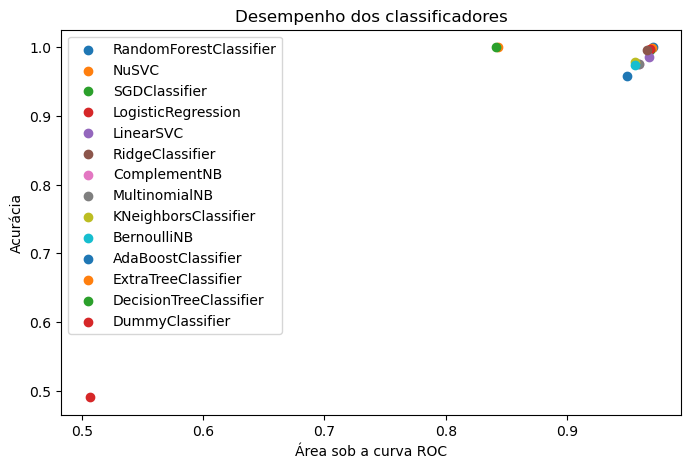

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.to_dict('records'):
    label = record['name']
    x = record['auc']
    y = record['accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos classificadores')
ax.legend()
plt.show()


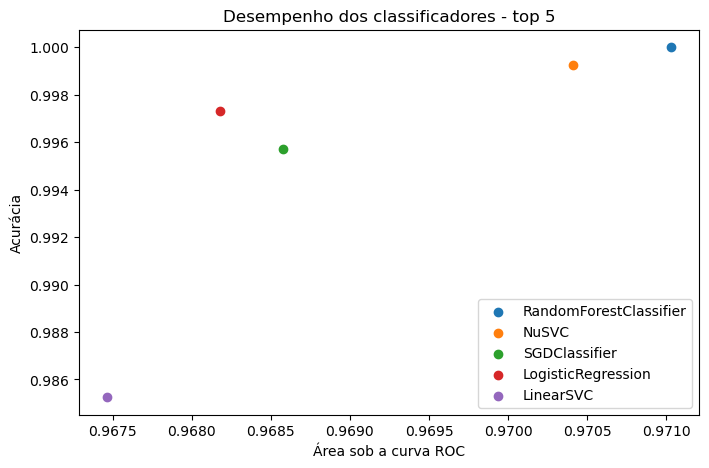

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.head(5).to_dict('records'):
    label = record['name']
    x = record['auc']
    y = record['accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos classificadores - top 5')
ax.legend()
plt.show()

## Ajustando hiperparâmetros do vetorizador

### Carregar arquivo de hyperparâmetros dos classificadores

In [28]:
    # "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    # "vectorizer__min_df": (1, 3, 5, 10),
    # "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # "vectorizer__norm": ("l1", "l2"),